In [1]:
device = 'cpu'


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm as tqdm
from diffusers import AutoencoderKL
import matplotlib.pyplot as plt


In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64, 64)),
])

train_dataset = torchvision.datasets.ImageFolder('data/celeba_hq/train', transform=transforms)
# test_dataset = torchvision.datasets.QMNIST('data', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training with {len(train_dataset)} samples")
# print(f"Testing with {len(test_dataset)} samples")


Training with 28000 samples


In [4]:
model = AutoencoderKL(latents_mean=0, latents_std=1).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-3)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1750 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


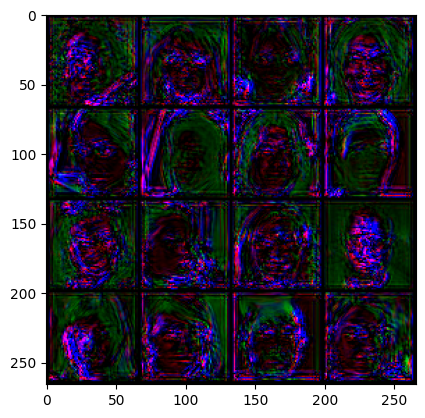

KeyboardInterrupt: 

In [5]:
model.train()
with tqdm.notebook.tnrange(10) as epochs:
    epochs.set_description_str("Epoch")
    for epoch in epochs:
        with tqdm.notebook.tqdm(train_loader, leave=False) as progress:
            progress.set_description_str("Batch")
            for img, _ in progress:
                
                optimizer.zero_grad()
                img = img.to(device)
                out = model(img)[0]
                loss = criterion(out, img)
                loss.backward()
                optimizer.step()
                
                if progress.n % 10 == 0:
                    with torch.no_grad():
                        # model.eval()
                        # imgs = model.decoder(torch.randn(16, 4, 64, 64, device=device))
                        grid = torchvision.utils.make_grid(out, nrow=4)
                        plt.imshow(grid.permute(1, 2, 0).cpu())
                        plt.show()
                
                progress.set_postfix_str(f"Loss: {loss.item():.4f}")
                progress.update()
        epochs.set_postfix_str(f"Loss: {loss.item():.4f}")
        epochs.update()


In [ ]:
with torch.no_grad():
    model.eval()
    imgs = model.decoder(torch.randn(16, 4, 64, 64, device=device))
    grid = torchvision.utils.make_grid(imgs, nrow=4)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.show()
